<a href="https://colab.research.google.com/github/100471975/GRUPO14_Practica1/blob/main/p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1

Carlos Seguí Cabrera (100472060)

Rubén de Arriba Viejo (100471975)

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from scipy.stats import randint
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
import time
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline



seed = 100471975

def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
def r2(y_test, y_pred):
  return np.clip(metrics.r2_score(y_test, y_pred), 0, 1)

pattern = re.compile("([a-zA-z0-9.]*\.13|energy|datetime)")
def filter_columns(col):
  """ Función que filtra para que se utilicen las columnas que terminen en .13 """
  return bool(pattern.match(col))

La función *filter_columns* devuelve True si el nombre de la columna termina en ".13" ó si es la columna "energy". Para evaluar que tan bueno es el modelo generado, vamos a utilizar el error cuadrático medio (rmse).

## EDA
En esta sección se va a realizar la lectura e interpretación de los datos proporcionados en el problema.

In [2]:
# Ejecutar solo en colab
from google.colab import drive

drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Curso3/AprendizajeAutomatico/p1/wind_ava.csv.gz", compression='gzip', usecols=filter_columns)
data.info()

ModuleNotFoundError: No module named 'google.colab'

In [306]:
# Ejecutar si no estas en Colab
import os

data = pd.read_csv(os.getcwd() + "/wind_ava.csv.gz", compression='gzip', usecols=filter_columns)



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    4748 non-null   object 
 1   energy      4748 non-null   float64
 2   p54.162.13  4748 non-null   float64
 3   p55.162.13  4748 non-null   float64
 4   cape.13     4748 non-null   float64
 5   p59.162.13  4748 non-null   float64
 6   lai_lv.13   4748 non-null   float64
 7   lai_hv.13   4748 non-null   float64
 8   u10n.13     4748 non-null   float64
 9   v10n.13     4748 non-null   float64
 10  sp.13       4748 non-null   float64
 11  stl1.13     4748 non-null   float64
 12  u10.13      4748 non-null   float64
 13  v10.13      4748 non-null   float64
 14  t2m.13      4748 non-null   float64
 15  stl2.13     4748 non-null   float64
 16  stl3.13     4748 non-null   float64
 17  iews.13     4748 non-null   float64
 18  inss.13     4748 non-null   float64
 19  stl4.13     4748 non-null  

La lista creada con las columnas con algún valor nulo está vacía, podemos asegurar que la base de datos seleccionada no tiene valores nulos.
Con esto, habríamos filtrado los datos de tal forma que solo quedan los relacionados con la estación número 13, la energía y el día en el que se tomó la muestra.
Debido a los valores de los datos y a lo que pide el enunciado, se trata de un problema de regresión, ya que se quiere saber la cantidad de energía producida en base a los 22 parámetros evaluados, siendo una salida continua.

In [307]:
# Vamos a ver la varianza de los datos para comprobar el estado inicial de nuestro problema.

# Damos un valor numérico a la variable datetime para poder operar con ella
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'] = data['datetime'].astype(int) / 10**9


print(data.var())
# Eliminamos la columna datetime por tener una varianza demasiado elevada
data.drop(columns=['datetime'], inplace=True)

datetime      2.143766e+15
energy        4.429323e+05
p54.162.13    2.009369e+09
p55.162.13    4.293153e+01
cape.13       1.482525e+04
p59.162.13    2.151950e+12
lai_lv.13     1.579087e-01
lai_hv.13     1.355691e-02
u10n.13       9.613612e+00
v10n.13       9.100875e+00
sp.13         5.093529e+05
stl1.13       4.114356e+01
u10.13        9.973619e+00
v10.13        9.355127e+00
t2m.13        3.798852e+01
stl2.13       3.077972e+01
stl3.13       2.100230e+01
iews.13       1.346989e-01
inss.13       1.436517e-01
stl4.13       1.262291e+01
fsr.13        5.779241e-05
flsr.13       8.903704e-03
u100.13       2.344235e+01
v100.13       2.178604e+01
dtype: float64


Calculando la varianza de cada uno de los parámetros, podemos ver que la varianza de la variable datetime tiene una varianza muy elevada. Esto significa que los valores se alejan bastante de la media y pueden provocar errores a la hora de hacer un análiasis estadístico. Por este motivo, hemos decidido eliminar la variable datetime de nuestro modelo.

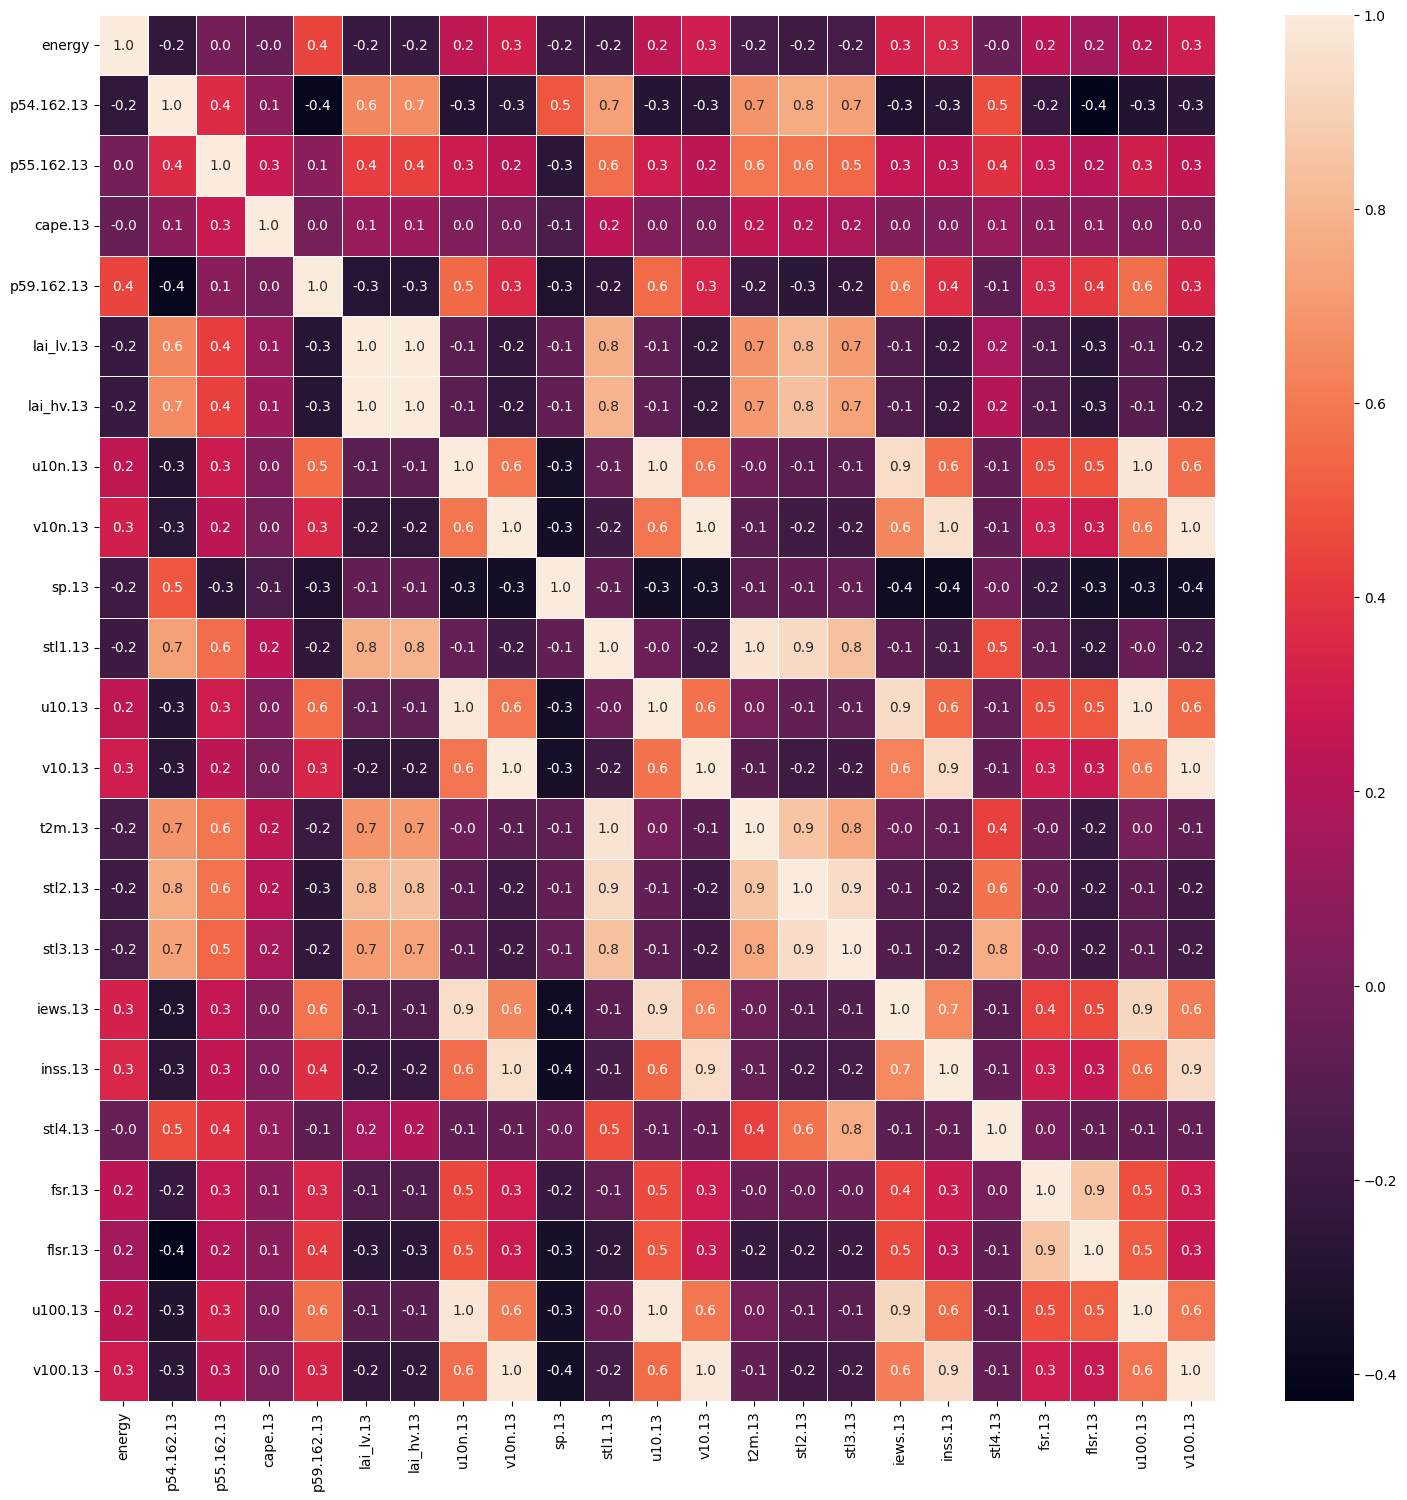

In [308]:
# Vamos a comprobar la correlación entre las variables para ver cuales de ellas están relacionadas

corr_Matrix = data.corr ()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap (corr_Matrix, linewidths = 0.5, annot = True, fmt= '.1f',ax=ax)
plt.show ()

Con la correlación calculada, podemos ver que hay varios datos con una alta correlación entre ellos (u10, u10n y u100 por ejemplo). Esto indicaría que, usando uno de ellos, los tres estarían representados por aportar una información muy similar, pero de momento decidimos no quitar ninguno de los parámetros.
También podemos ver que la variable p59.162 es la que tiene mayor correlación con la energía, por lo que podemos suponer que será de las más importantes a la hora de generar el modelo.

In [113]:
print(data)

       energy    p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  \
0      402.71  2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   
1      696.80  2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   
2     1591.15  2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   
3     1338.62  2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   
4      562.50  2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   
...       ...           ...         ...        ...           ...        ...   
4743  1280.13  2.385772e+06   14.413342  24.971074  3.905586e+06   2.349839   
4744   855.00  2.385708e+06   12.802883  60.248874  2.745694e+06   2.349446   
4745   117.06  2.379049e+06   10.915997   3.145067  2.254171e+06   2.349054   
4746   516.96  2.371697e+06   13.048144  12.580268  1.376913e+06   2.347799   
4747   867.07  2.369547e+06    9.172745   8.487892  1.356687e+06   2.347406   

      lai_hv.13   u10n.13   v10n.13         sp.13  

Viendo el conjunto de datos que queda, es un conjunto con todo valores reales, por lo que no haría falta ninguna binarización de datos.
Por todo esto, se da por terminada la parte de EDA.

## Generación de modelos con parámetros por defecto:
Primero debemos, utilizando el modelo KNN, decidir que escalado vamos a utilizar. Para esto, vamos a escalar los datos de tres formas diferentes: *StandardScaler* (hace que los datos tengan una media de 0 y una desviación estándar de 1), *MinMaxScaler* (transforma los datos para que queden en el rango [0, 1]) y *MaxAbsScaler* (transforma los datos para que queden en el rango [0, 1]).
Vamos a comparar la mejora de los distintos datos sobre el modelo Dummy, que estima por la media del conjunto.
Como métricas para evaluar los modelos hemos decidido utilizar el RMSE, que es fácil de interpretar y es sensible a errores grandes, y R2, que hace más fácil comparar los modelos generados con el modelo Dummy.

In [310]:
# Definimos las variables sobre las que vamos a hacer los modelos KNN
X = data.drop(columns=['energy'])
y = data['energy']

X_MaxAbs = MaxAbsScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

### Modelo Dummy
Este modelo consiste en el clasificador más sencillo que se puede generar y servirá como referencia para futuros clasificadores.

Hemos decidido utilizar la mediana ya que, por la distribución de los datos, hay mucha más presencia de energías bajas que altas.

In [311]:
t1 = time.time()

# Crear el regresor dummy que predice siempre la mediana
dummy_regressor = DummyRegressor(strategy="median")

# Entrenar el regresor dummy
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = dummy_regressor.predict(X_test)

print("\033[94;1m" + f"- RMSE del modelo dummy: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "- Duración del modelo:", time.time()-t1)
print()


- RMSE del modelo dummy: 683.2086270418359
- El R2 calculado es de: 0.0
- Duración del modelo: 0.009395599365234375



Como se puede ver en el modelo normalizado, el rmse es muy elevado, lo que implica que este modelo predice muy mal. Esto es de esperarse, ya que se basa en la media de los datos de entrenamiento para predecir. El R2 indica que el modelo no tiene la capacidad de hacer buenas predicciones y no se ajusta bien a los datos.

### Modelo KNN
Para este modelo se va a hacer una lista de modelos con distintos valores para K. De esta forma podremos averiguar cuál es el número más acertado de vecinos que debemos utilizar.

In [312]:
t1 = time.time()

min_RMSE = 12000000
min_k_RMSE = 0
min_R2 = 0
min_k_R2 = 0

escalador = StandardScaler()
# Crear el regresor KNN
X_train_StandardScaler = escalador.fit_transform(X_train)
X_train_StandardScaler = pd.DataFrame(X_train_StandardScaler, columns=X_train.columns)
X_test_StandardScaler = escalador.transform(X_test)
X_test_StandardScaler = pd.DataFrame(X_test_StandardScaler, columns=X_test.columns)

for k in range(5, 101):

  knn_regressor = KNeighborsRegressor(n_neighbors=k)

  # Entrenar el regresor KNN
  knn_regressor.fit(X_train_StandardScaler, y_train)

  # Hacer predicciones en el conjunto de prueba
  y_pred = knn_regressor.predict(X_test_StandardScaler)
  if min_RMSE > rmse(y_test, y_pred):
    min_RMSE = rmse(y_test, y_pred)
    min_k_RMSE = k
  if min_R2 < r2(y_test, y_pred):
    min_R2 = r2(y_test, y_pred)
    min_k_R2 = k

print("Resultados StandardScaler:")
print("\t" + "\033[94;1m" + f"- RMSE del modelo KNN (K={min_k_RMSE}): {min_RMSE}")
print("\t" + f"- R2 del modelo KNN (K={min_k_R2}): {min_R2}")
print("\t" + "\033[0m" + "- Duración del modelo:", time.time()-t1)
print()

t2 = time.time()
min_RMSE = 12000000
min_k_RMSE = 0
min_R2 = 0
min_k_R2 = 0

escalador = MinMaxScaler()
# Crear el regresor KNN
X_train_MinMax = escalador.fit_transform(X_train)
X_train_MinMax = pd.DataFrame(X_train_MinMax, columns=X_train.columns)
X_test_MinMax = escalador.transform(X_test)
X_test_MinMax = pd.DataFrame(X_test_MinMax, columns=X_test.columns)


for k in range(5, 101):
  knn_regressor = KNeighborsRegressor(n_neighbors=k)
  # Entrenar el regresor KNN
  knn_regressor.fit(X_train_MinMax, y_train)
  # Hacer predicciones en el conjunto de prueba
  y_pred = knn_regressor.predict(X_test_MinMax)
  if min_RMSE > rmse(y_test, y_pred):
    min_RMSE = rmse(y_test, y_pred)
    min_k_RMSE = k
  if min_R2 < r2(y_test, y_pred):
    min_R2 = r2(y_test, y_pred)
    min_k_R2 = k

print("Resultados MinMax:")
print("\t" + "\033[94;1m" + f"- RMSE del modelo KNN (K={min_k_RMSE}): {min_RMSE}")
print("\t" + f"- R2 del modelo KNN (K={min_k_R2}): {min_R2}")
print("\t" + "\033[0m" + "- Duración del modelo:", time.time()-t1)
print()


t3 = time.time()


min_RMSE = 12000000
min_k_RMSE = 0
min_R2 = 0
min_k_R2 = 0

escalador = MaxAbsScaler()
# Crear el regresor KNN
X_train_MaxAbs = escalador.fit_transform(X_train)
X_train_MaxAbs = pd.DataFrame(X_train_MaxAbs, columns=X_train.columns)
X_test_MaxAbs = escalador.transform(X_test)
X_test_MaxAbs = pd.DataFrame(X_test_MaxAbs, columns=X_test.columns)


# Crear el regresor KNN
for k in range(5, 101):
  knn_regressor = KNeighborsRegressor(n_neighbors=k)

  # Entrenar el regresor KNN
  knn_regressor.fit(X_train_MaxAbs, y_train)

  # Hacer predicciones en el conjunto de prueba
  y_pred = knn_regressor.predict(X_test_MaxAbs)
  if min_RMSE > rmse(y_test, y_pred):
    min_RMSE = rmse(y_test, y_pred)
    min_k_RMSE = k
  if min_R2 < r2(y_test, y_pred):
    min_R2 = r2(y_test, y_pred)
    min_k_R2 = k

print("Resultados MaxAbs")
print("\t" + "\033[94;1m" + f"- RMSE del modelo KNN (K={min_k_RMSE}): {min_RMSE}")
print("\t" + f"- R2 del modelo KNN (K={min_k_R2}): {min_R2}")
print("\t" + "\033[0m" + "- Duración del modelo:", time.time()-t3)
print()
print("Duración total:", time.time()-t1)

Resultados StandardScaler:
	- RMSE del modelo KNN (K=13): 388.97697146582084
	- R2 del modelo KNN (K=13): 0.6403328444065414
	- Duración del modelo: 4.269457101821899

Resultados MinMax:
	- RMSE del modelo KNN (K=14): 407.7033211344819
	- R2 del modelo KNN (K=14): 0.6048686416061901
	- Duración del modelo: 8.57659101486206

Resultados MaxAbs
	- RMSE del modelo KNN (K=12): 381.62937708114623
	- R2 del modelo KNN (K=12): 0.6537924010726313
	- Duración del modelo: 3.30049729347229

Duración total: 11.877260684967041


De esta forma, podemos ver que los mejores resultados se obtienen utilizando el escalado MaxAbs. Esto es gracias a que este escalado no es sensible a valores atípicos, al contrario de StandardScaler, que utiliza la media y la desviación estándar para el escalado.

Por estarazón, se va a el escalado MaxAbs para los próximos modelos. La mayoría de modelos se van a ejecutar sin utilizar un Pipeline, pero para el modelo final si que vamos a utilizarlo para que no haga falta modificar los datos que se deseen predecir.

In [313]:
# Eliminamos los datos que no vamos a utilizar

del(X_test_MinMax)
del(X_train_MinMax)
del(X_test_StandardScaler)
del(X_train_StandardScaler)

Ahora vamos a buscar cuales son los mejores parámetros para el modelo KNN:

In [314]:
params = {
    'n_neighbors': range(1, 21),
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
}

# Inicializamos el regresor
knn = KNeighborsRegressor()
t1 = time.time()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
)

grid_search.fit(X_train_MaxAbs, y_train)
y_pred = grid_search.predict(X_test_MaxAbs)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("\033[94;1m" + "- Valor de RMSE:", rmse(y_test, y_pred))
print("- Valor de R2:", r2(y_test, y_pred))
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)

Mejores hiperparámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 11}
- Valor de RMSE: 379.24877448109834
- Valor de R2: 0.6580982126018385
Tiempo de ejecución: 7.03126859664917


De esta forma, podemos ver que los mejores parámetros para el regresor KNN son k = 11 y la distancia utilizada es la distancia Manhattan.

### Árboles de Regresión
En esta sección vamos a generar un único árbol y posteriormente un random forest, para tener la mayor cantidad de modelos de referencia posibles.

En estos modelos es indiferente utilizar los datos escalados o los datos sin escalar, pero, por usar siempre los mismos datos, se van a usar los datos escalados.

**Árbol único**

En primera instancia vamos a evaluar el modelo con los parámetros por defecto.

In [315]:
t1 = time.time()

# Crear el árbol de regresión
decision_tree_regressor = DecisionTreeRegressor(random_state=seed)

# Entrenar el árbol de regresión
decision_tree_regressor.fit(X_train_MaxAbs, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = decision_tree_regressor.predict(X_test_MaxAbs)

print("\033[94;1m" + f"- RMSE del modelo árbol de regresión: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "Duración del modelo:", time.time()-t1)

- RMSE del modelo árbol de regresión: 499.01206206657844
- El R2 calculado es de: 0.4080635466821808
Duración del modelo: 0.12579703330993652


Buscamos los mejores parámetros para el Árbol de Regresión

In [316]:
# Definimos los parámetros a utilizar
t1 = time.time()
params = {
    'max_depth': range(1, 21),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 21)
}

# Inicializamos el regresor
tree_regressor = DecisionTreeRegressor(random_state=seed)

budget = 100

random_search = RandomizedSearchCV(
    estimator=tree_regressor,
    param_distributions=params,
    n_iter=budget,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
    random_state=seed
)

random_search.fit(X_train_MaxAbs, y_train)
y_pred = random_search.predict(X_test_MaxAbs)

print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("\033[94;1m" + "- Valor de RMSE:", rmse(y_test, y_pred))
print("- Valor de R2:", r2(y_test, y_pred))
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)

Mejores hiperparámetros encontrados: {'min_samples_split': 6, 'min_samples_leaf': 19, 'max_depth': 9}
- Valor de RMSE: 409.35260686980195
- Valor de R2: 0.601665318937004
Tiempo de ejecución: 26.402832508087158


**Random Forest**

Primero miramos el modelo con los parámetros por defecto

In [317]:
t1 = time.time()
# Dividir los datos en conjuntos de entrenamiento y prueba

# Crear el modelo de Random Forest Regression
rf_regressor = RandomForestRegressor(random_state=seed)

# Entrenar el modelo
rf_regressor.fit(X_train_MaxAbs, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test_MaxAbs)

print("\033[94;1m" + f"- RMSE del modelo Random Forest: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)


- RMSE del modelo Random Forest: 357.28806666819764
- El R2 calculado es de: 0.6965479880369994
Tiempo de ejecución: 8.132799625396729


Buscamos los mejores parámetros para el Random Forest

In [318]:
start = time.time()

budget = 40

params = {'n_estimators': range(20, 301, 20),
          'max_features': [1, 3, 6, 9, 12, 15, 18, 21],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=seed),
    scoring="neg_root_mean_squared_error",
    param_distributions=params,
    cv=KFold(n_splits=5, shuffle=True, random_state=seed),
    n_jobs=-1,
    verbose=False,
    random_state=seed,
    n_iter=budget
)

random_search.fit(X_train_MaxAbs, y_train)

y_pred = random_search.predict(X_test_MaxAbs)

print("Los mejores hiperparámetros encontrados son:", random_search.best_params_)
print("\033[94;1m" + f"- El RMSE calculado es de: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)


Los mejores hiperparámetros encontrados son: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 12}
- El RMSE calculado es de: 353.9154166957899
- El R2 calculado es de: 0.7022498689791404
Tiempo de ejecución: 106.42359519004822


### Regresor lineal
Primero ejecutamos la regresión linea y luego observaremos cómo queda la importancia de cada uno de los coeficientes.

- RMSE del modelo Regresor Lineal: 533.5569521602024
- El R2 calculado es de: 0.32327134682593683
Tiempo de ejecución: 0.046944379806518555


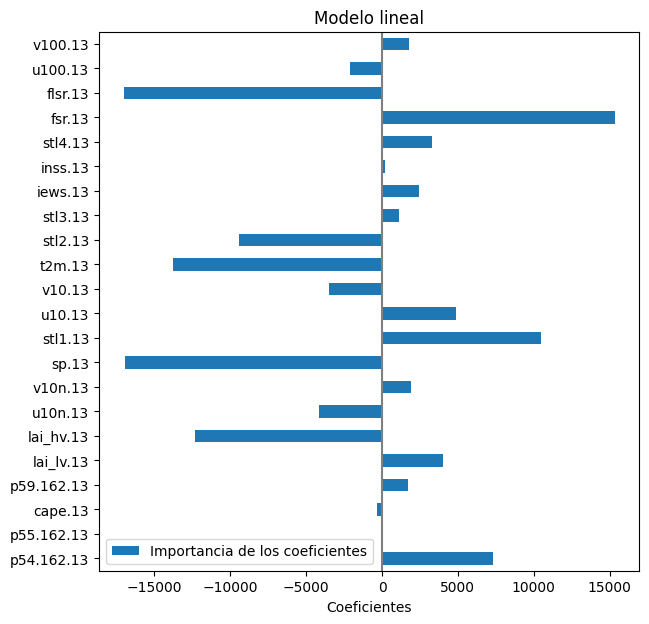

In [319]:
t1 = time.time()
# Dividir los datos en conjuntos de entrenamiento y prueba

# Crear el modelo de regresión lineal
linear_regressor = LinearRegression()

# Entrenar el modelo
linear_regressor.fit(X_train_MaxAbs, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = linear_regressor.predict(X_test_MaxAbs)

print("\033[94;1m" + f"- RMSE del modelo Regresor Lineal: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)

feature_names = X_train_MaxAbs.columns
coefs = pd.DataFrame(linear_regressor.coef_,
                     columns=['Importancia de los coeficientes'],
                     index=feature_names)
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo lineal")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

**Lasso**

Vamos a aplicar el modelo Lasso para mejorar los valores de los coeficientes. Para hacer más sencilla la ejecución vamos a utilizar un pipeline

- RMSE del modelo Lasso: 533.4332745117604
- El R2 calculado es de: 0.3235850397046275
Valor óptimo de alfa: 0.004150404757850477
Tiempo de ejecución: 1.2081010341644287


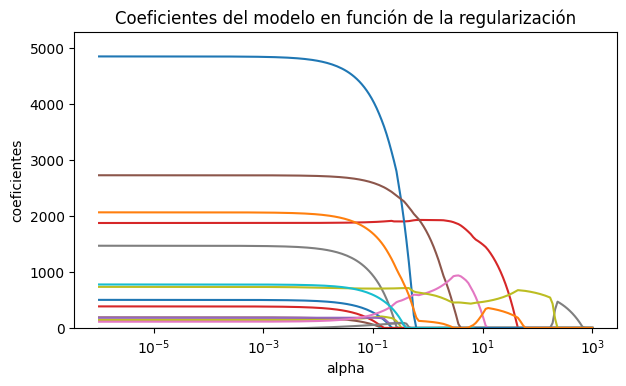

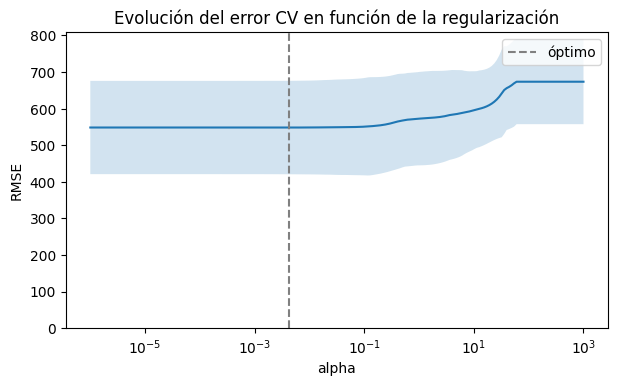

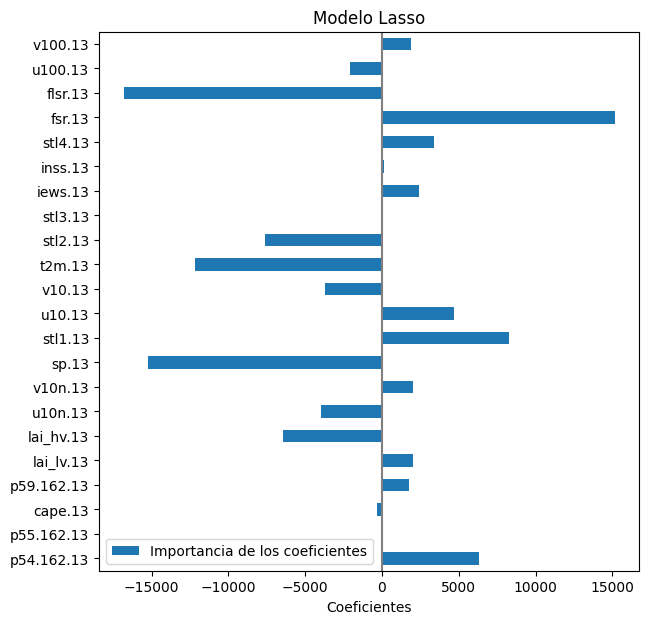

In [320]:
alphas=np.logspace(-6, 3, 200)
coefs=[]

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha, fit_intercept=False)
    lasso_regressor.fit(X_train_MaxAbs, y_train)
    coefs.append(lasso_regressor.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-2.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')


# Crear el modelo de Lasso
t1 = time.time()

pipe_regrLasso = LassoCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=seed))
# Entrenar el modelo
np.random.seed(seed)
pipe_regrLasso.fit(X_train_MaxAbs, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = pipe_regrLasso.predict(X_test_MaxAbs)

# Imprimir el RMSE y R2 score del modelo
print("\033[94;1m" + f"- RMSE del modelo Lasso: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
best_alpha = pipe_regrLasso.alpha_
print("\033[0m" + "Valor óptimo de alfa:", best_alpha)
print("Tiempo de ejecución:", time.time()-t1)

mse_cv = pipe_regrLasso.mse_path_.mean(axis=1)
mse_sd = pipe_regrLasso.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = pipe_regrLasso.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = pipe_regrLasso.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(pipe_regrLasso.alphas_, rmse_cv)
ax.fill_between(
    pipe_regrLasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()


# Obtener los nombres de las características
feature_names = X_train_MaxAbs.columns

# Obtener los coeficientes del modelo Lasso
coefs = pd.DataFrame(
    pipe_regrLasso.coef_,
    columns=['Importancia de los coeficientes'],
    index=feature_names
)

# Crear el gráfico de barras horizontales
coefs.plot.barh(figsize=(9, 7))
plt.title("Modelo Lasso")
plt.xlabel("Coeficientes")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()



Como se puede ver, al utilizar la regularización Lasso, el valor de RMSE y R2 se ven ligeramente afectados, pero el modelo final es más simple, es decir, hay coeficientes cuyo valor es 0, por lo que no aparecen, y hay otros cuyo valor es muy cercano a 0.

### Modelo SVM
Primero ejecutamos el modelo con parámetros por defecto. EN este modelo vamos a utilizar un pipeline de ejecución

In [321]:
t1 = time.time()

# Crear el modelo SVM para regresión
# Usamos un pipeline para poder meter los datos sin escalar
pipe_regr_radial_def = Pipeline([('escalar', MaxAbsScaler()), ('SVM', SVR())])

# Entrenar el modelo
np.random.seed(seed)
pipe_regr_radial_def.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = pipe_regr_radial_def.predict(X_test)

print(pipe_regr_radial_def['SVM'].C, pipe_regr_radial_def['SVM'].gamma)
print("\033[94;1m" + f"- RMSE del modelo SVM: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)

1.0 scale
- RMSE del modelo SVM: 657.1636050940764
- El R2 calculado es de: 0.0
Tiempo de ejecución: 0.8619942665100098


Ahora procedemos a buscar los valores que hagan óptimo el modelo SVM

In [322]:
start = time.time()

params = {'SVM__C': [1, 10, 100, 1000, 10000, 100000],
          'SVM__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Usamos un pipeline para poder meter los datos sin escalar
pipe_regr_radial_def = Pipeline([
    ('escalador', MaxAbsScaler()),
    ('SVM', SVR())
    ])

budget=100

SVM_ajustado = RandomizedSearchCV(pipe_regr_radial_def,
                              params,
                              scoring='neg_mean_squared_error',
                              cv=KFold(n_splits=5, shuffle=True, random_state=seed),
                              n_jobs=-1, verbose=1,
                              n_iter=budget
                             )
np.random.seed(seed)
SVM_ajustado.fit(X_train, y_train)

y_pred = SVM_ajustado.predict(X_test)

print("Los mejores hiperparámetros encontrados son:", SVM_ajustado.best_params_)
print("\033[94;1m" + f"- El RMSE calculado es de: {rmse(y_test, y_pred)}")
print(f"- El R2 calculado es de: {r2(y_test, y_pred)}")
print("\033[0m" + f"Tiempo de ejecucion: {time.time() - start}")


Fitting 5 folds for each of 42 candidates, totalling 210 fits


Los mejores hiperparámetros encontrados son: {'SVM__gamma': 1, 'SVM__C': 10000}
- El RMSE calculado es de: 343.18642223816875
- El R2 calculado es de: 0.7200289065797352
Tiempo de ejecucion: 101.64122724533081


### Conclusiones
Como se puede ver, el mejor método para la regresión es el modelo SVM, ya que su tiempo de ejecución es muy bajo y es el que mejores valores obtiene (RMSE = 0.1222 y R2 = 0.723). Los resultados ajustando hiperparámetros, en general, son mejores respecto a los valores obtenidos con los hiperparámetros por defecto, solo en los regresores lineales se obtienen resultados ligeramente peores. Esto ocurre porque se hace un reajuste de los coeficientes para simplificar el modelo perdiendo la menor cantidad de información, por lo que, a pesar de ser una peor solución, es preferible debido a su simplicidad.

Todos los modelos, cuando se realiza el ajuste de parámetros, aumentan su tiempo de ejecución, lo que es normal debido a que se están realizando varios modelos de forma simultánea y se están evaluando entre ellos para ver cuál es el mejor. Sin embargo, si no se dan unos parámetros de búsqueda demasiado extensos, el ajuste de parámetros siempre será preferible para poder hallar un modelo mejor.

## Modelo Final Regresión
Con todos los hiperparámetros calculados anteriormente, vamos a generar el modelo final con el SVM con los parámetros calculados para que sea óptimo

In [323]:
from sklearn.metrics import make_scorer
import pickle


MODELO_FINAL = SVM_ajustado.best_estimator_
outer = KFold(n_splits=5, shuffle=True, random_state=seed)

scores = cross_val_score(MODELO_FINAL,
                         X_train_MaxAbs,
                         y_train,
                         scoring=make_scorer(rmse),
                         cv=outer)

print("El rendimiento del RMSE del modelo a futiro es:\033[94;1m",scores.mean())
MODELO_FINAL.fit(X, y)
with open("modelo_final.pkl", "wb") as f:
    pickle.dump(MODELO_FINAL, f)

El rendimiento del RMSE del modelo a futiro es: 363.39935611336944


Una vez hemos entrenado el modelo final, hacemos predicciones sobre los datos de competición.

In [324]:
import pickle

data_comp = pd.read_csv(os.getcwd() + "/wind_comp.csv.gz", compression='gzip', usecols=filter_columns)
data_comp.drop(columns=['datetime'], inplace=True)
X_comp = data_comp.drop(columns=['energy'])

with open("modelo_final.pkl", "rb") as f:
    MODELO = pickle.load(f)
y_pred = MODELO.predict(X_comp)
predicciones_df = pd.DataFrame(data=y_pred, columns=['energy'])

# Guardar las predicciones en un archivo CSV
predicciones_df.to_csv('predicciones.csv', index=False)

print("Los valores obtenidos en las predicciones son:")
print("\033[94;1m" + "- RMSE =", rmse(data_comp['energy'], y_pred))
print("- R2 =", r2(data_comp['energy'], y_pred))

Los valores obtenidos en las predicciones son:
- RMSE = 358.4942249042283
- R2 = 0.7423921414163895


## Clasificación

Primero separamos los datos y transformamos los valores de energía.

In [325]:
import copy

data_classify = copy.deepcopy(data)


tercer_cuantil = data_classify['energy'].quantile(3/4)
# Función para transformar los datos
def energy_to_binary(energy_value):
    return (1 if energy_value >= tercer_cuantil else 0)

# Aplicamos la transformación de los datos
data_classify['energy'] = data_classify['energy'].apply(energy_to_binary)




In [326]:
# Separamos las columnas
X_classify = data_classify.drop(columns=['energy'])
y_classify = data_classify['energy']

# Separamos los datos en entrenamiento y test
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split(X_classify, y_classify, test_size=0.33, random_state=seed, stratify=y_classify)

Vamos a comprobar como predice nuestro modelo tanto los valores altos de energía como los bajos

### Random Forest

Al estar trabajando con datos sumamente desbalanceados (25% clase alta y 75% clase baja), debemos realizar una separación especial a la hora de separar los datos para ser evaluados.

Vamos a utilizar para la evaluación del modelo el f1-score y el balanced-accuracy-score, ya que ambos valores tienen en cuenta el desbalanceo de los datos.

Con los datos ya separados, entrenamos el Random Forest

In [327]:
t1 = time.time()

# Crear el modelo de Random Forest Regression
rf_classifier = RandomForestClassifier(random_state=seed)

# Entrenar el modelo
rf_classifier.fit(X_train_stratified, y_train_stratified)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test_stratified)


print("\033[94;1m" + f"- F1-score del modelo Random Forest: {f1_score(y_test_stratified, y_pred)}")
print(f"- Balanced accuracy del modelo Random Forest: {balanced_accuracy_score(y_test_stratified, y_pred)}")
print("\033[0m" + "Tiempo de ejecución:", time.time()-t1)


- F1-score del modelo Random Forest: 0.7450980392156863
- Balanced accuracy del modelo Random Forest: 0.8154559270516717
Tiempo de ejecución: 1.5340700149536133


Hacemos una búsqueda de hiperparámetros para optimizar el modelo

In [328]:
param_dist = {'n_estimators': range(100, 1001, 20),
          'max_features': range(2,20),
}
# Crear un objeto RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=seed)

budget = 25

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, 
                                   param_distributions=param_dist,
                                   n_iter=budget, 
                                   cv=KFold(n_splits=5, shuffle=True, random_state=seed),
                                   refit='f1',
                                   random_state=seed,
                                   scoring="balanced_accuracy",
                                   n_jobs=-1)

# Entrenar el modelo
t1 = time.time()
random_search.fit(X_train_stratified, y_train_stratified)
print("Tiempo de búsqueda de hiperparámetros:", time.time()-t1)
t2 = time.time()
# Obtener los mejores hiperparámetros y resultados
best_params = random_search.best_params_



Tiempo de búsqueda de hiperparámetros: 451.7069592475891


In [329]:
print(best_params)
y_pred = random_search.predict(X_test_stratified)
print(f1_score(y_test_stratified, y_pred))
print(balanced_accuracy_score(y_test_stratified, y_pred))
MODELO_FINAL_CLASIFICACION = random_search.best_estimator_


{'n_estimators': 720, 'max_features': 7}
0.7535014005602241
0.8205590534085975


Como se puede observar, el modelo con los mejores parámetros tiene `n_estimators = 720`  y `max_features = 7`.

Generamos el modelo de clasificación final.

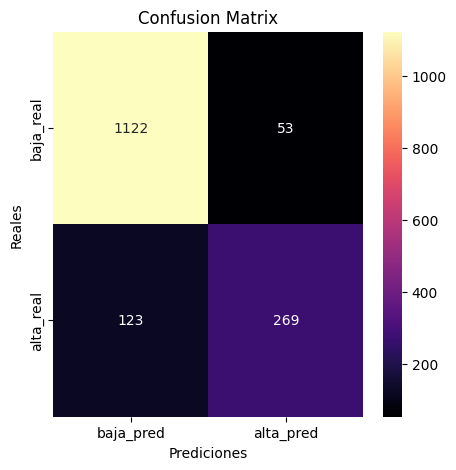


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1175
           1       0.84      0.69      0.75       392

    accuracy                           0.89      1567
   macro avg       0.87      0.82      0.84      1567
weighted avg       0.88      0.89      0.88      1567



In [330]:
from sklearn.metrics import classification_report, confusion_matrix

# Vemos su comportamiento con los datos de competicion
data_classify_comp = copy.deepcopy(data_comp)
data_classify_comp['energy'] = data_classify_comp['energy'].apply(energy_to_binary)


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_stratified, y_pred)

# Crear el heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='magma', fmt='g',
            xticklabels=['baja_pred', 'alta_pred'],
            yticklabels=['baja_real', 'alta_real'])
plt.xlabel('Prediciones')
plt.ylabel('Reales')
plt.title('Confusion Matrix')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test_stratified, y_pred))

### Conclusiones

El modelo final de clasificación generado, como era predecible, es mejor a la hora de predecir los valores bajos de energía que los altos. Esto es porque la clase de energías altas esta menos representada que su complementaria, esto se puede ver en el valor de recall en la clase alta (1).

En general, el modelo tiene buenos valores de clasificación.

## ChatGPT

Para el proyecto, tal y como se especificaba en la práctica, hemos utilizado la herramienta para distintas funciones:
- Deputación de errores, es decir, cuando la celda ejecutada fallaba, le dábamos a chat el error y el código afectado para saber como solucionarlo.
- Explicación de código e hiperparámetros. Para saber qué se hacía y de qué manera en cada uno de los tutoriales seguidos para la realización de la práctica, hemos preguntado a chat por líneas específicas y lo que hacían. Para los hiperparámetros, hemos preguntado qué hiperparámetros debíamos tener en cuenta, para hacer una mejor selección de los mismos.
- Impresión en ficheros. Debido a que con python no hemos tenido una amplia experiencia usando librerias de escritura/lectura de ficheros, hemos preguntado a chatGPT cómo realizarlo.

En definitiva, hemos usado chatGPT para lograr un mayor entendimiento general de la práctica.